In [1]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
os.chdir("drive/My Drive/MLCaseStudy")

In [4]:
!ls

catboost_info  dataset.csv


In [5]:
!pip install xgboost

In [6]:
!pip install catboost

In [7]:
full_data = pd.read_csv(r"dataset.csv",sep=";")

In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier,BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

In [9]:
cat_columns_from_dataDict = ["default","account_status","account_worst_status_0_3m","account_worst_status_12_24m","account_worst_status_3_6m",
                       "account_worst_status_6_12m","merchant_category","merchant_group","has_paid","name_in_email","status_last_archived_0_24m",
                       "status_2nd_last_archived_0_24m","status_3rd_last_archived_0_24m","status_max_archived_0_6_months","status_max_archived_0_12_months",
                       "status_max_archived_0_24_months","worst_status_active_inv"]

In [10]:
train_data = full_data.loc[(full_data['default'] == 0.0) | (full_data['default'] == 1.0)]
pred_data = full_data.loc[(full_data['default'] != 0.0) & (full_data['default'] != 1.0)]

In [11]:
train_data.isnull().mean().sort_values(ascending=False)

worst_status_active_inv                0.695074
account_worst_status_12_24m            0.667456
account_worst_status_6_12m             0.603639
account_incoming_debt_vs_paid_0_24m    0.593014
account_worst_status_3_6m              0.577243
account_status                         0.543856
account_worst_status_0_3m              0.543856
avg_payment_span_0_3m                  0.493265
avg_payment_span_0_12m                 0.238597
num_active_div_by_paid_inv_0_12m       0.229595
num_arch_written_off_12_24m            0.181215
num_arch_written_off_0_12m             0.181215
account_days_in_term_12_24m            0.118732
account_days_in_dc_12_24m              0.118732
account_days_in_rem_12_24m             0.118732
sum_capital_paid_account_0_12m         0.000000
age                                    0.000000
status_max_archived_0_12_months        0.000000
status_max_archived_0_24_months        0.000000
recovery_debt                          0.000000
status_2nd_last_archived_0_24m         0

In [12]:
df = train_data.loc[:, train_data.isnull().mean() < .49]

In [13]:
df.describe()

,default,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,age,avg_payment_span_0_12m,max_paid_inv_0_12m,max_paid_inv_0_24m,num_active_div_by_paid_inv_0_12m,num_active_inv,num_arch_dc_0_12m,num_arch_dc_12_24m,num_arch_ok_0_12m,num_arch_ok_12_24m,num_arch_rem_0_12m,num_arch_written_off_0_12m,num_arch_written_off_12_24m,num_unpaid_bills,status_last_archived_0_24m,status_2nd_last_archived_0_24m,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,status_max_archived_0_12_months,status_max_archived_0_24_months,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours
count,89976.000000,8.997600e+04,79293.000000,79293.000000,79293.000000,89976.000000,68508.000000,89976.000000,89976.000000,69318.000000,89976.000000,89976.000000,89976.000000,89976.000000,89976.000000,89976.000000,73671.000000,73671.000000,89976.000000,89976.000000,89976.000000,89976.000000,89976.000000,89976.000000,89976.000000,89976.000000,89976.000000,89976.000000,8.997600e+04,89976.000000
mean,0.014315,1.227615e+04,0.217333,5.073840,0.287894,36.019050,17.977933,9224.090658,11244.316873,0.114667,0.598704,0.061761,0.059749,7.289777,6.380702,0.467258,0.000109,0.000136,2.142249,0.922791,0.827987,0.744499,0.800258,1.051547,1.225782,4.044401,10833.659832,6579.854317,3.921349e+04,15.336351
std,0.118786,3.546356e+04,5.629972,22.957817,2.930697,12.999713,12.804216,13576.947551,15257.546930,0.293679,1.544341,0.373620,0.368212,16.074663,15.397921,1.351350,0.010420,0.012762,6.296635,0.569607,0.622776,0.634204,0.719561,0.785793,0.833651,167.324157,26494.078628,19192.785345,8.940011e+04,5.030674
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000278
25%,0.000000,0.000000e+00,0.000000,0.000000,0.000000,25.000000,10.800000,2000.000000,3340.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.630000e+03,11.629167
50%,0.000000,0.000000e+00,0.000000,0.000000,0.000000,34.000000,14.904762,6055.000000,7585.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.600000e+04,15.800833
75%,0.000000,4.984250e+03,0.000000,0.000000,0.000000,45.000000,21.040124,11380.000000,13810.000000,0.100000,1.000000,0.000000,0.000000,7.000000,6.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,0.000000,9098.250000,100.000000,4.389925e+04,19.548056
max,1.000000,1.128775e+06,362.000000,365.000000,97.000000,100.000000,260.000000,279000.000000,279000.000000,9.000000,47.000000,16.000000,13.000000,261.000000,313.000000,42.000000,1.000000,2.000000,182.000000,5.000000,5.000000,5.000000,3.000000,5.000000,5.000000,36479.000000,571475.000000,341859.000000,2.962870e+06,23.999722


In [14]:
missing_data_cols = (df.loc[:,df.isnull().mean() > 0]).columns
missing_data_cols

Index(['account_days_in_dc_12_24m', 'account_days_in_rem_12_24m',
       'account_days_in_term_12_24m', 'avg_payment_span_0_12m',
       'num_active_div_by_paid_inv_0_12m', 'num_arch_written_off_0_12m',
       'num_arch_written_off_12_24m'],
      dtype='object')

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(strategy='mean')
scaler = StandardScaler()

for col in missing_data_cols:
  df[col] = imp_mean.fit_transform(df[col].values.reshape(-1,1))
  df[col] = scaler.fit_transform(df[col].values.reshape(-1,1))

In [16]:
df.isnull().mean().sort_values(ascending=False)

time_hours                          0.0
merchant_category                   0.0
num_active_div_by_paid_inv_0_12m    0.0
name_in_email                       0.0
max_paid_inv_0_24m                  0.0
max_paid_inv_0_12m                  0.0
has_paid                            0.0
merchant_group                      0.0
avg_payment_span_0_12m              0.0
num_arch_dc_0_12m                   0.0
age                                 0.0
account_days_in_term_12_24m         0.0
account_days_in_rem_12_24m          0.0
account_days_in_dc_12_24m           0.0
account_amount_added_12_24m         0.0
default                             0.0
num_active_inv                      0.0
num_arch_dc_12_24m                  0.0
sum_paid_inv_0_12m                  0.0
status_3rd_last_archived_0_24m      0.0
sum_capital_paid_account_12_24m     0.0
sum_capital_paid_account_0_12m      0.0
recovery_debt                       0.0
status_max_archived_0_24_months     0.0
status_max_archived_0_12_months     0.0


In [17]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

le = LabelEncoder()
categorical_features = [col for col in df.columns if (col in cat_columns_from_dataDict and col != "default")]
categorical_indexes = [df.columns.get_loc(col)for col in df.columns if (col in cat_columns_from_dataDict and col != "default")]
other_indexes = [i for i in range(df.shape[1]) if i not in categorical_indexes]
for column in categorical_features:
    print("column name : ",column)
    df[column] = le.fit_transform(df[column])

# from sklearn.compose import ColumnTransformer
# ct = ColumnTransformer([('one_hot_encoder', OneHotEncoder(categories='auto'), [0])],remainder='passthrough')

# df = ct.fit_transform(df)
# df= df[:, 1:]

column name :  merchant_category
column name :  merchant_group
column name :  has_paid
column name :  name_in_email
column name :  status_last_archived_0_24m
column name :  status_2nd_last_archived_0_24m
column name :  status_3rd_last_archived_0_24m
column name :  status_max_archived_0_6_months
column name :  status_max_archived_0_12_months
column name :  status_max_archived_0_24_months


In [18]:
type(df)

pandas.core.frame.DataFrame

In [19]:
print('No Defaults', round(df['default'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Defaults', round(df['default'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Defaults 98.57 % of the dataset
Defaults 1.43 % of the dataset


Text(0.5, 1.0, 'Class Distributions \n (0: No Default || 1: Default)')

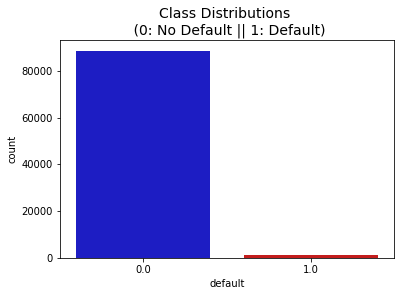

In [20]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('default', data=df, palette=colors)
plt.title('Class Distributions \n (0: No Default || 1: Default)', fontsize=14)

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit


X = df.drop('default', axis=1)
y = df['default']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
# original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the Distribution of the labels


# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

Train: [17985 17986 17987 ... 89973 89974 89975] Test: [    0     1     2 ... 18255 18392 18678]
Train: [    0     1     2 ... 89973 89974 89975] Test: [17985 17986 17987 ... 38664 38699 38700]
Train: [    0     1     2 ... 89973 89974 89975] Test: [35967 35968 35969 ... 55702 55918 55920]
Train: [    0     1     2 ... 89973 89974 89975] Test: [53954 53955 53956 ... 72693 72694 72848]
Train: [    0     1     2 ... 72693 72694 72848] Test: [71974 71975 71976 ... 89973 89974 89975]
Label Distributions: 

[0.98569067 0.01430933]
[0.98566268 0.01433732]


# Random Undersampling

More balanced dataset which avoids the model to overfit

In [22]:
#Randomize the order of all rows in the dataframe
df = df.sample(frac=1)

In [23]:
num_default = len([i for i in list(y) if i == 1.0])
num_default

1288

In [24]:
default_df = df.loc[df['default'] == 1.0]
non_default_df = df.loc[df['default'] == 0][:num_default]

balanced_subSampled_df = pd.concat([default_df, non_default_df])

new_df = balanced_subSampled_df.sample(frac=1, random_state=42)

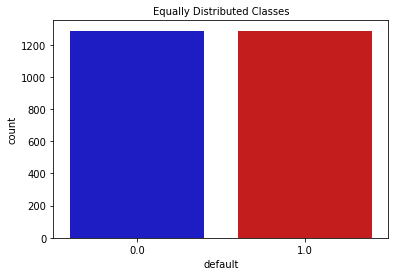

In [25]:
sns.countplot('default', data=new_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=10)
plt.show()

# Correlation HeatMap in the full dataset vs sub sampled dataset

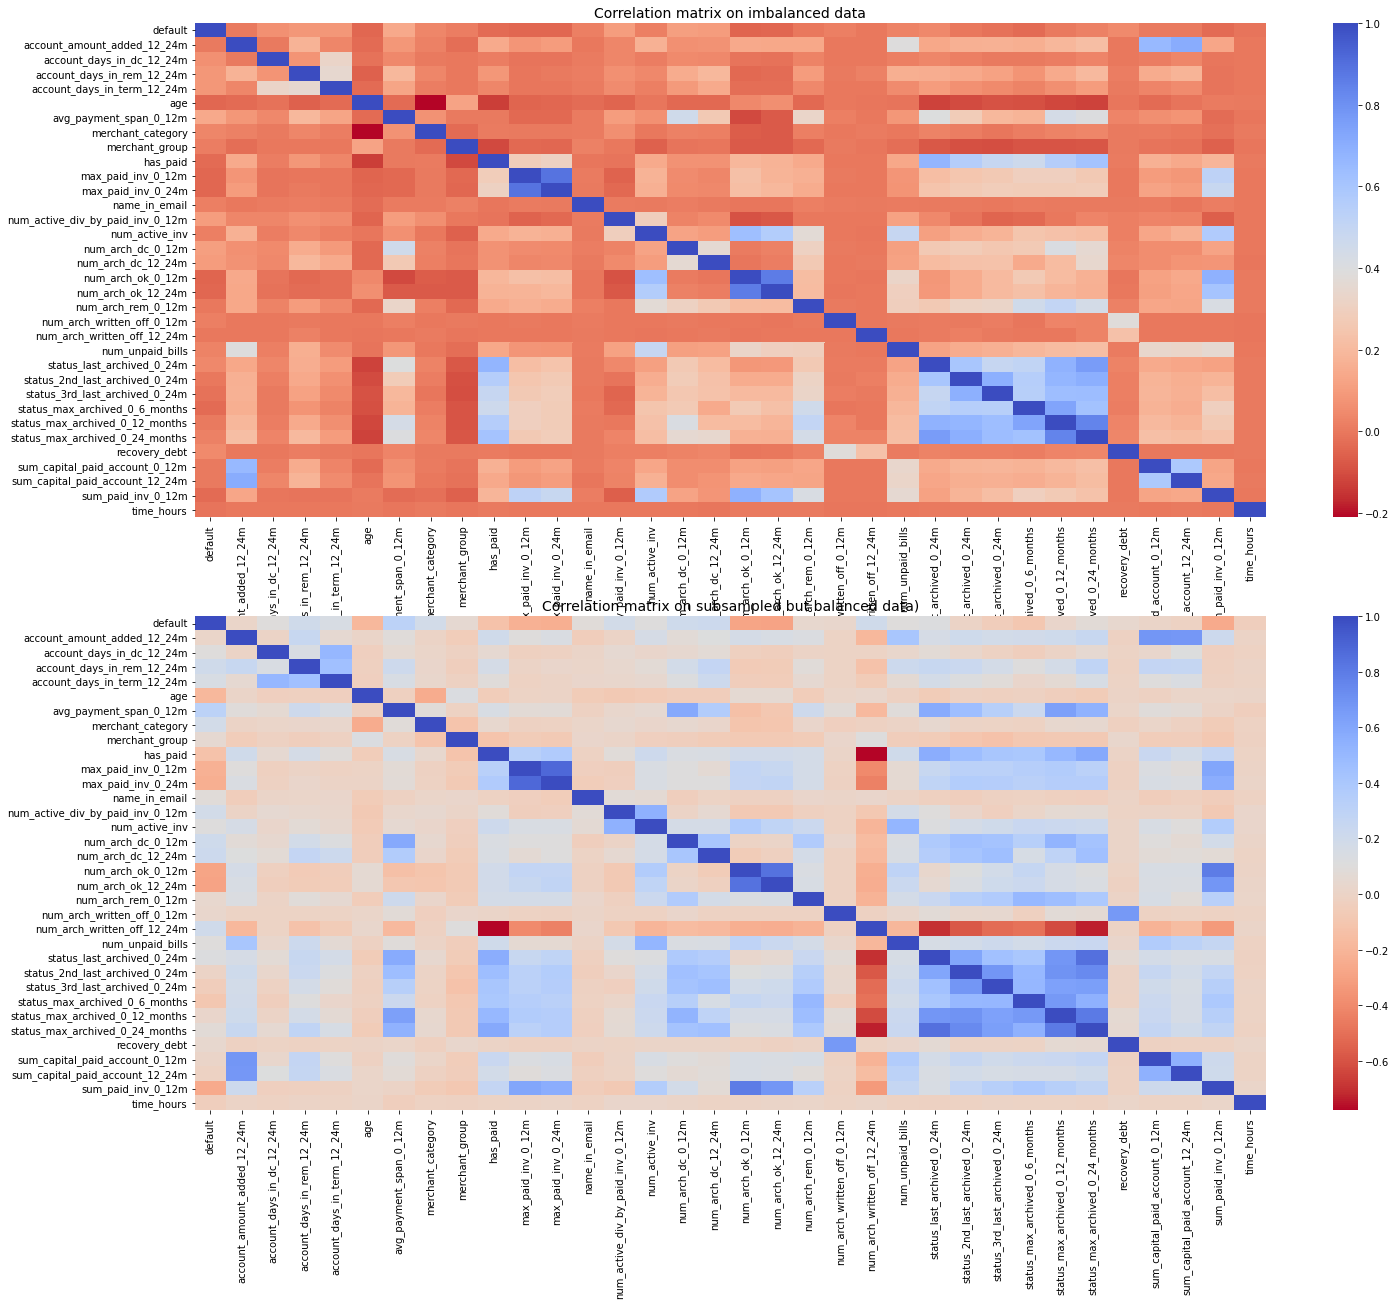

In [26]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Correlation matrix on imbalanced data", fontsize=14)

sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('Correlation matrix on subsampled but balanced data)', fontsize=14)
plt.show()

# Inference from the correlation heatmap
Looking at the above correlation heatmap, the features **age, has_paid, max_paid_inv_0_12m, max_paid_inv_0_24m, num_arch_ok_0_12m, num_arch_ok_12_24m, status_max_archived_0_6_months, sum_paid_inv_0_12m are negatively correlated**.This means that lesser these values are it is more likely that end result is a default observation.

# Visualising the negative correlations

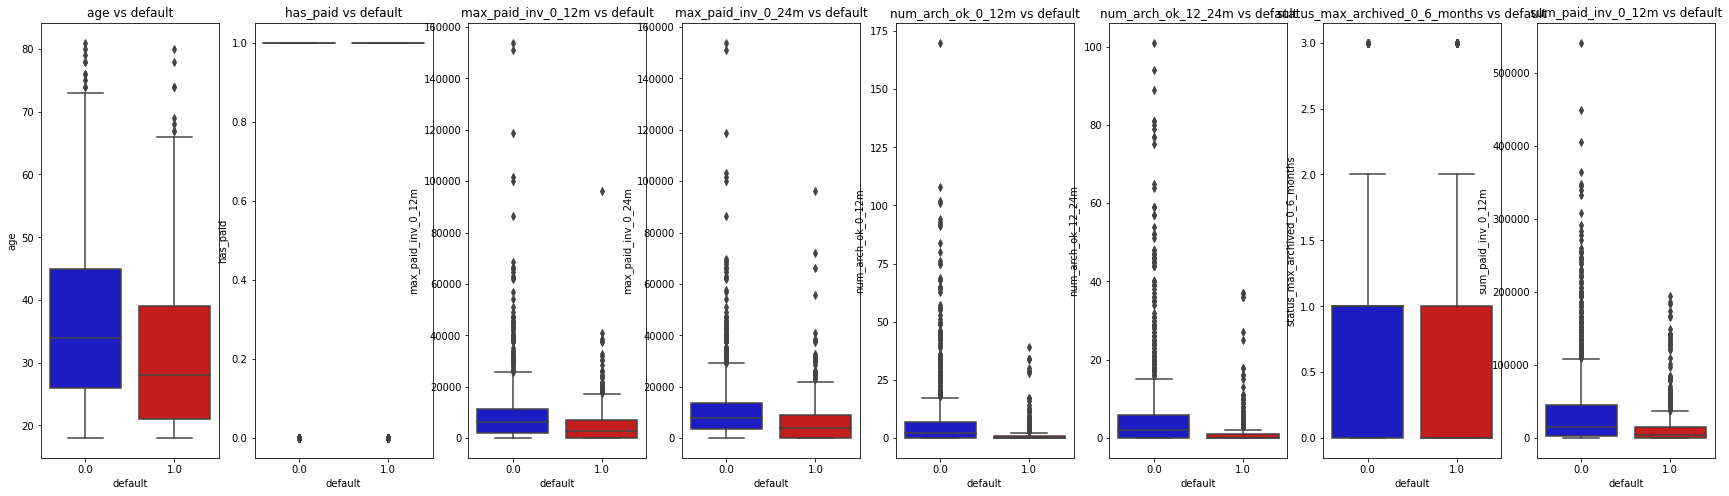

In [27]:
f, axes = plt.subplots(ncols=8, figsize=(30,8))

sns.boxplot(x="default", y="age", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('age vs default')

sns.boxplot(x="default", y="has_paid", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('has_paid vs default')


sns.boxplot(x="default", y="max_paid_inv_0_12m", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('max_paid_inv_0_12m vs default')


sns.boxplot(x="default", y="max_paid_inv_0_24m", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('max_paid_inv_0_24m vs default')

sns.boxplot(x="default", y="num_arch_ok_0_12m", data=new_df, palette=colors, ax=axes[4])
axes[4].set_title('num_arch_ok_0_12m vs default')

sns.boxplot(x="default", y="num_arch_ok_12_24m", data=new_df, palette=colors, ax=axes[5])
axes[5].set_title('num_arch_ok_12_24m vs default')


sns.boxplot(x="default", y="status_max_archived_0_6_months", data=new_df, palette=colors, ax=axes[6])
axes[6].set_title('status_max_archived_0_6_months vs default')


sns.boxplot(x="default", y="sum_paid_inv_0_12m", data=new_df, palette=colors, ax=axes[7])
axes[7].set_title('sum_paid_inv_0_12m vs default')

plt.show()

# Clustering the subsample to find clusters of default and non default data points

In [28]:
X = new_df.drop(['uuid','default'], axis=1)
y = new_df['default']

X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)

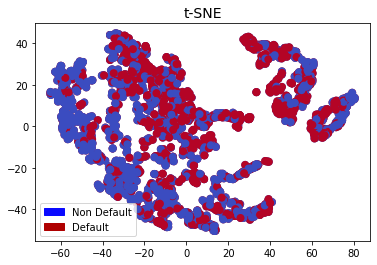

In [29]:
# t-SNE scatter plot
blue_patch = mpatches.Patch(color='#0A0AFF', label='Non Default')
red_patch = mpatches.Patch(color='#AF0000', label='Default')
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=(y == 0.0), cmap='coolwarm', label='Non Default', linewidths=2)
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=(y == 1.0), cmap='coolwarm', label='Default', linewidths=2)
plt.title(label='t-SNE', fontdict = {'fontsize':14})

plt.legend(handles=[blue_patch, red_patch])
plt.show()

# Dimensionality reduction using PCA

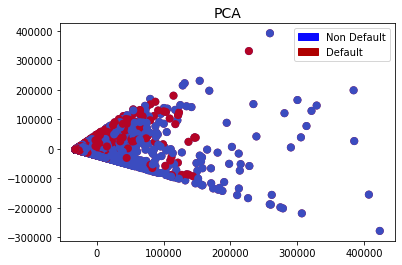

In [30]:
X_PCA= PCA(n_components=2, random_state=42).fit_transform(X.values)
plt.scatter(X_PCA[:,0], X_PCA[:,1], c=(y == 0.0), cmap='coolwarm', label='Non Default', linewidths=2)
plt.scatter(X_PCA[:,0], X_PCA[:,1], c=(y == 1.0), cmap='coolwarm', label='Default', linewidths=2)
plt.title(label='PCA', fontdict = {'fontsize':14})
plt.legend(handles=[blue_patch, red_patch])
plt.show()

# Visualizing the clusters using kmeans clustering

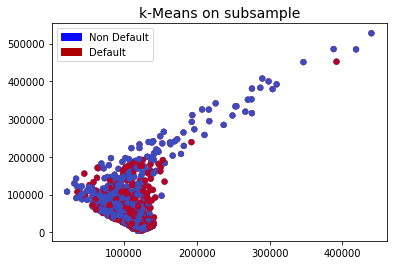

In [31]:
from sklearn.cluster import KMeans

X_kmeans_subsample = KMeans(n_clusters= 2).fit_transform(X.values)
plt.scatter(X_kmeans_subsample[:,0], X_kmeans_subsample[:,1], c=(y == 0.0), cmap='coolwarm', label='Non Default', linewidths=0.25)
plt.scatter(X_kmeans_subsample[:,0], X_kmeans_subsample[:,1], c=(y == 1.0), cmap='coolwarm', label='Default', linewidths=0.25)
plt.title(label='k-Means on subsample', fontdict = {'fontsize':14})
plt.legend(handles=[blue_patch, red_patch])
plt.show()

In [32]:
X = new_df.drop(['uuid','default'], axis=1)
y = new_df['default']

In [33]:
from sklearn.model_selection import train_test_split

# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [34]:
# Let's implement simple classifiers
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "AdaBoostClassifier": AdaBoostClassifier(),
    "GradientBoostingClassifier": GradientBoostingClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "NaiveBayesClassifier": GaussianNB(),
    "RandomForestClassifier": RandomForestClassifier(),
    "XgBoostClassifier": XGBClassifier(),
    "LightGBMClassifier": LGBMClassifier(),
    "CatBoostClassifier": CatBoostClassifier(verbose=False)
}

In [35]:
from sklearn.model_selection import cross_val_score

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifier: ", key, "has a training score of", round(training_score.mean() * 100, 2), "% accuracy score")

Classifier:  LogisiticRegression has a training score of 66.41 % accuracy score
Classifier:  KNearest has a training score of 64.37 % accuracy score
Classifier:  Support Vector Classifier has a training score of 64.32 % accuracy score
Classifier:  AdaBoostClassifier has a training score of 78.79 % accuracy score
Classifier:  GradientBoostingClassifier has a training score of 79.95 % accuracy score
Classifier:  DecisionTreeClassifier has a training score of 71.99 % accuracy score
Classifier:  NaiveBayesClassifier has a training score of 62.38 % accuracy score
Classifier:  RandomForestClassifier has a training score of 80.39 % accuracy score
Classifier:  XgBoostClassifier has a training score of 80.44 % accuracy score
Classifier:  LightGBMClassifier has a training score of 80.24 % accuracy score
Classifier:  CatBoostClassifier has a training score of 81.12 % accuracy score


# Inferece from the Cross Validation Score
The ensembling techniques like the boosting algorithms and Random Forest performs better on the undersampled dataset. We will emphasize more on these algorithms to select the best model that well predicts the defaulters.

In [36]:
selected_classifiers = {
    "AdaBoostClassifier": AdaBoostClassifier(),
    "GradientBoostingClassifier": GradientBoostingClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "XgBoostClassifier": XGBClassifier(),
    "LightGBMClassifier": LGBMClassifier(),
    "CatBoostClassifier": CatBoostClassifier(verbose=False)
}

In [37]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score

predictionsDict = {}
for key, classifier in selected_classifiers.items():
  
    y_pred = cross_val_predict(classifier, X_train, y_train, cv=5,
                             method="predict_proba")
    y_pred = [np.argmax(i) for i in y_pred]
    rocScore =  roc_auc_score(y_train, y_pred)
    predictionsDict[key] = y_pred
    print("Classifier: ",key, "has a ROC AUC score of", round(rocScore * 100,2), "%")

Classifier:  AdaBoostClassifier has a ROC AUC score of 78.76 %
Classifier:  GradientBoostingClassifier has a ROC AUC score of 79.91 %
Classifier:  RandomForestClassifier has a ROC AUC score of 80.45 %
Classifier:  XgBoostClassifier has a ROC AUC score of 80.39 %
Classifier:  LightGBMClassifier has a ROC AUC score of 80.22 %
Classifier:  CatBoostClassifier has a ROC AUC score of 81.08 %


# Further Inference from ROC AUC Score analysis
From the above results **Random Forest, CatBoost, LightGBM are the top 3 models** that best fits the data

# ROC Curve Analysis

In [38]:
rf_fpr, rf_tpr, rf_thresold = roc_curve(y_train, predictionsDict["RandomForestClassifier"])
cb_fpr, cb_tpr, cb_thresold = roc_curve(y_train, predictionsDict["CatBoostClassifier"])
lgbm_fpr, lgbm_tpr, lgbm_thresold = roc_curve(y_train, predictionsDict["LightGBMClassifier"])

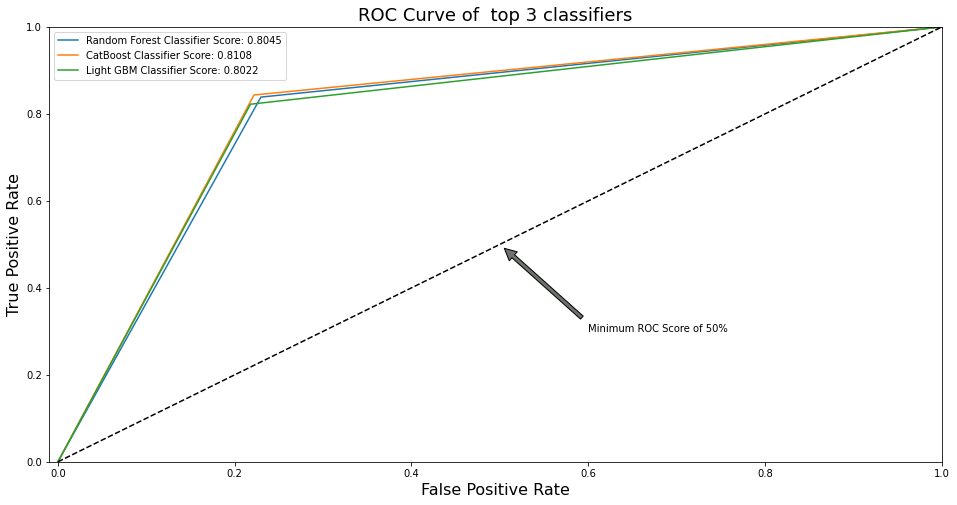

In [39]:
def plot_roc_curve(rf_fpr, rf_tpr,cb_fpr, cb_tpr,lgbm_fpr, lgbm_tpr,predictionsDict):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve of  top 3 classifiers', fontsize=18)
    plt.plot(rf_fpr, rf_tpr, label='Random Forest Classifier Score: {:.4f}'.format(roc_auc_score(y_train, predictionsDict["RandomForestClassifier"])))
    plt.plot(cb_fpr, cb_tpr, label='CatBoost Classifier Score: {:.4f}'.format(roc_auc_score(y_train, predictionsDict["CatBoostClassifier"])))
    plt.plot(lgbm_fpr, lgbm_tpr, label='Light GBM Classifier Score: {:.4f}'.format(roc_auc_score(y_train, predictionsDict["LightGBMClassifier"])))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50%', xy=(0.5, 0.5), xytext=(0.6, 0.3),arrowprops=dict(facecolor='#6E726D', shrink=0.05))
    plt.legend()
    
plot_roc_curve(rf_fpr, rf_tpr,cb_fpr, cb_tpr,lgbm_fpr, lgbm_tpr,predictionsDict)
plt.show()

# Inference from ROC Curve:
**As we can see from the above ROC curve plot, CatBoost has the maximum AUC (Area under the curve) which means this model performs better in distinguishing the default and non default cases.**

Let us apply these classifiers that best performed on the subsample on the complete dataset

In [53]:
X = df.drop(['uuid','default'], axis=1)
y = df['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train = X_train.values.astype(str)
X_test = X_test.values.astype(str)
y_train = y_train.values
y_test = y_test.values

In [54]:
clf = CatBoostClassifier(iterations=50,random_seed=42,learning_rate=0.5,custom_loss=['AUC', 'Accuracy'])
clf.fit(X_train, y_train,cat_features=[X.columns.get_loc(i) for i in categorical_features],eval_set=(X_test, y_test),verbose=False,plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [55]:
y_pred_proba=clf.predict_proba(X_test)
y_pred_proba

array([[9.99700062e-01, 2.99938319e-04],
       [9.94540983e-01, 5.45901681e-03],
       [9.94030235e-01, 5.96976541e-03],
       ...,
       [9.99218864e-01, 7.81135908e-04],
       [9.13527681e-01, 8.64723187e-02],
       [9.88987352e-01, 1.10126483e-02]])

In [56]:
y_pred=clf.predict(X_test)

In [57]:
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
def confusion_heatMap(confusionMatrix):
  class_names=[0,1]
  fig, ax = plt.subplots()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names)
  plt.yticks(tick_marks, class_names)
  sns.heatmap(pd.DataFrame(confusionMatrix), annot=True, cmap="YlGnBu" ,fmt='g')
  ax.xaxis.set_label_position("top")
  plt.tight_layout()
  plt.title('Confusion matrix', y=1.1)
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

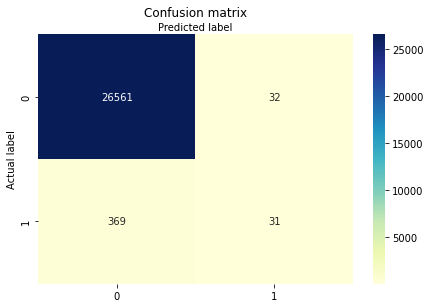

In [58]:
confusion_heatMap(confusion_matrix(y_test,y_pred))

In [59]:
accuracy_score(y_test, y_pred)

0.9851442966695069

In [60]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     26593
         1.0       0.49      0.08      0.13       400

    accuracy                           0.99     26993
   macro avg       0.74      0.54      0.56     26993
weighted avg       0.98      0.99      0.98     26993



In [61]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

catboost_clf = CatBoostClassifier()
# Creating the hyperparameter grid
param_dist = { "learning_rate": np.linspace(0,0.2,5),"max_depth": randint(3, 10)}

rscv = RandomizedSearchCV(catboost_clf , param_dist, scoring='accuracy', cv =5,verbose=False)

#Fit the model
rscv.fit(X_train,y_train)

# Print the tuned parameters and score
print(rscv.best_params_)
print(rscv.best_score_)

  

Streaming output truncated to the last 5000 lines.
2:	learn: 0.4395892	total: 33.3ms	remaining: 11.1s
3:	learn: 0.3818714	total: 44.3ms	remaining: 11s
4:	learn: 0.3332897	total: 55.2ms	remaining: 11s
5:	learn: 0.2933079	total: 65.4ms	remaining: 10.8s
6:	learn: 0.2580060	total: 75.5ms	remaining: 10.7s
7:	learn: 0.2297150	total: 86.6ms	remaining: 10.7s
8:	learn: 0.2064290	total: 97.6ms	remaining: 10.7s
9:	learn: 0.1865806	total: 109ms	remaining: 10.8s
10:	learn: 0.1694225	total: 122ms	remaining: 11s
11:	learn: 0.1545756	total: 133ms	remaining: 10.9s
12:	learn: 0.1429891	total: 143ms	remaining: 10.9s
13:	learn: 0.1311060	total: 155ms	remaining: 10.9s
14:	learn: 0.1215956	total: 166ms	remaining: 10.9s
15:	learn: 0.1140947	total: 177ms	remaining: 10.9s
16:	learn: 0.1076558	total: 188ms	remaining: 10.9s
17:	learn: 0.1018623	total: 208ms	remaining: 11.4s
18:	learn: 0.0973732	total: 224ms	remaining: 11.6s
19:	learn: 0.0926862	total: 235ms	remaining: 11.5s
20:	learn: 0.0890619	total: 246ms	rema

# {'learning_rate': 0.1, 'max_depth': 7}
# 0.9859168319071066

In [62]:
clf_best = CatBoostClassifier(**rscv.best_params_,verbose=False)
clf_best.fit(X_train,y_train)

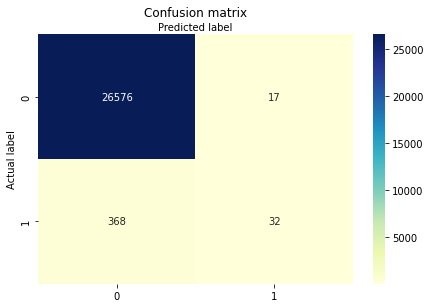

In [63]:
y_best_pred=clf_best.predict(X_test)
confusion_heatMap(confusion_matrix(y_test,y_best_pred))

In [64]:
accuracy_score(y_test, y_best_pred)

0.9857370429370578

In [65]:
print(classification_report(y_test,y_best_pred))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     26593
         1.0       0.65      0.08      0.14       400

    accuracy                           0.99     26993
   macro avg       0.82      0.54      0.57     26993
weighted avg       0.98      0.99      0.98     26993



# Train the data on the entire dataset to save the best predictor model

In [67]:
clf_final = CatBoostClassifier(**rscv.best_params_,verbose=False)
clf_final.fit(X,y)

In [70]:
import pickle

with open('default_predictor_05012022.pkl', 'wb') as files:
    pickle.dump(clf_final, files)